In [1]:
import pickle
import pandas as pd
import sklearn
import numpy as np
import scanpy as sc
import scipy.sparse
import anndata
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
import copy
import logging as logg
from sklearn import preprocessing
import os 
import warnings
import scATAcat
import seaborn as sns
import random as rn 

warnings.filterwarnings('ignore')

In [2]:
# set the seed for reproducibility
sd = 1234
np.random.seed(sd)
rn.seed(sd)
%env PYTHONHASHSEED=0


env: PYTHONHASHSEED=0


#### define necessary parameters

In [3]:
results_dir = "/project/scATAC_analysis/10X_scATAC_HumanBrain_Corces2020/analysis/scATAcat/results"
output_dir = results_dir+"/outputs/"
figures_dir = results_dir+"/figures/"
data_dir = "../"

for dir in [figures_dir, output_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)


### 0 - Load scATAC-seq data

In [4]:
ENCODE_coverage_per_cell_df= pickle.load(open('/project/scATAC_analysis/scATAcat_review/data/Corces2020_brain_scATAC/02_ENCODE_cCRE_coverage/human_brain_Corces2020_per_cell_encode_cCRE_matrix_sparse.pkl','rb'))

In [5]:
data_dir

'../'

In [6]:
ENCODE_cCREs = pd.read_csv(data_dir +"get_ENCODE_cCRE_by_cell_coverage/outs/rows.csv", index_col=0)
ENCODE_cCREs.columns = ["cCREs"]
ENCODE_cCREs.index = ENCODE_cCREs['cCREs']
ENCODE_cCREs.head()

,cCREs
cCREs,
chr1_181251_181601,chr1_181251_181601
chr1_190865_191071,chr1_190865_191071
chr1_778562_778912,chr1_778562_778912
chr1_779086_779355,chr1_779086_779355
chr1_779727_780060,chr1_779727_780060


In [7]:
cell_IDs = pd.read_csv(data_dir +"get_ENCODE_cCRE_by_cell_coverage/outs/columns.csv", index_col=0)
cell_IDs.columns = ["cell_IDs"]
cell_IDs.index = cell_IDs["cell_IDs"]
cell_IDs.head()

,cell_IDs
cell_IDs,
AAACGAAAGCAGAGCT-1,AAACGAAAGCAGAGCT-1
AAACGAAAGCTGATTC-1,AAACGAAAGCTGATTC-1
AAACGAAAGGACCGAT-1,AAACGAAAGGACCGAT-1
AAACGAAAGGAGTACC-1,AAACGAAAGGAGTACC-1
AAACGAAAGTCGTATC-1,AAACGAAAGTCGTATC-1


### 1 - initialize the AnnData object

In [8]:
sc_completeFeatures_adata = anndata.AnnData(ENCODE_coverage_per_cell_df.transpose(), var=ENCODE_cCREs, obs=cell_IDs)


In [9]:
sc_completeFeatures_adata

AnnData object with n_obs × n_vars = 10016 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'

### 2 - add binary layer to AnnData

In [10]:
scATAcat.add_binary_layer(sc_completeFeatures_adata, binary_layer_key="binary")

AnnData object with n_obs × n_vars = 10016 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    layers: 'binary'

## 3- calculate & plot cell and feature statistics

In [11]:
scATAcat.cell_feature_statistics(sc_completeFeatures_adata, binary_layer_key ='binary')

AnnData object with n_obs × n_vars = 10016 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

AnnData object with n_obs × n_vars = 10016 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

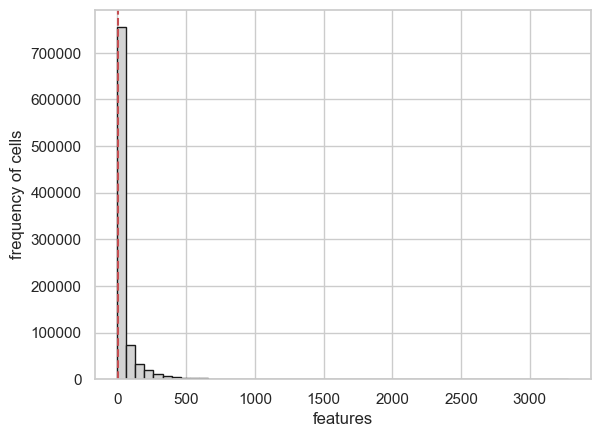

In [12]:
scATAcat.plot_feature_statistics(sc_completeFeatures_adata, threshold=3, bins=50, color="lightgrey", save=True, save_dir = figures_dir +"/feature_statistics_plot.png")

AnnData object with n_obs × n_vars = 10016 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

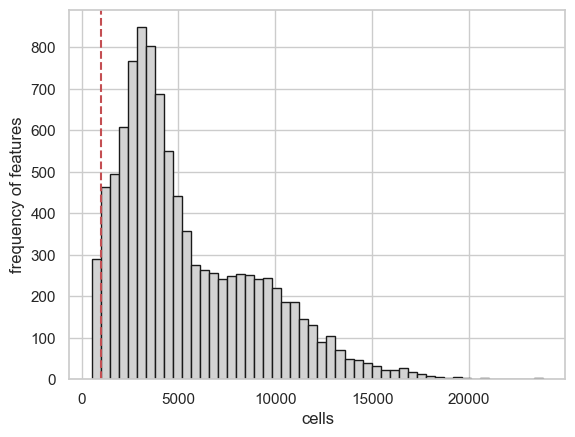

In [13]:
scATAcat.plot_cell_statistics(sc_completeFeatures_adata, threshold=1000, bins=50, color="lightgrey", save=True, save_dir = figures_dir + "/cell_statistics_plot.png")

## 4- filter the cells and features

In [14]:
sc_completeFeatures_adata

AnnData object with n_obs × n_vars = 10016 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

In [15]:
sc_filteredFeatures_adata = scATAcat.preproces_sc_matrix(sc_completeFeatures_adata,cell_cutoff=1000,cell_cutoff_max=80000, feature_cutoff=3, remove_chrY = True, var_key = 'cCREs', copy=True)

In [16]:
sc_filteredFeatures_adata

View of AnnData object with n_obs × n_vars = 9726 × 859230
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

### 5- load & preprocess the bulk data

In [17]:
#scATAC_analysis/scATAcat_notebooks_for_paper/jan2024/data/Corces2016_bulk_ATAC

In [18]:
bulk_by_ENCODE_peaks_df_annotated =  pickle.load(open( "/project/scATAC_analysis/10X_scATAC_HumanBrain_Corces2020/analysis/scATAcat/bulk_data/BOCA2bulkATAC_by_ENCODE_cCRE_overlappingPeaks_annotated.pkl", 'rb'))
bulk_by_ENCODE_peaks_df_annotated = bulk_by_ENCODE_peaks_df_annotated.reindex(sorted(bulk_by_ENCODE_peaks_df_annotated.columns), axis=1)

In [19]:
bulk_by_ENCODE_peaks_df_annotated.columns 

Index(['S1_GABA_ACC_1', 'S1_GABA_ACC_2', 'S1_GABA_DLPFC_1', 'S1_GABA_DLPFC_2',
       'S1_GABA_PVC_1', 'S1_GABA_PVC_2', 'S1_GLU_ACC_1', 'S1_GLU_ACC_2',
       'S1_GLU_DLPFC_1', 'S1_GLU_DLPFC_2', 'S1_GLU_PVC_1', 'S1_GLU_PVC_2',
       'S1_MGAS_ACC_1', 'S1_MGAS_ACC_2', 'S1_MGAS_DLPFC_1', 'S1_MGAS_DLPFC_2',
       'S1_MGAS_PVC_1', 'S1_MGAS_PVC_2', 'S1_OLIG_ACC_1', 'S1_OLIG_ACC_2',
       'S1_OLIG_DLPFC_1', 'S1_OLIG_DLPFC_2', 'S1_OLIG_PVC_1', 'S1_OLIG_PVC_2',
       'S2_GABA_DLPFC_1', 'S2_GABA_DLPFC_2', 'S2_GABA_PVC_1', 'S2_GABA_PVC_2',
       'S2_GLU_ACC_1', 'S2_GLU_ACC_2', 'S2_GLU_DLPFC_1', 'S2_GLU_DLPFC_2',
       'S2_GLU_PVC_1', 'S2_GLU_PVC_2', 'S2_MGAS_ACC_1', 'S2_MGAS_ACC_2',
       'S2_MGAS_DLPFC_1', 'S2_MGAS_DLPFC_2', 'S2_MGAS_PVC_1', 'S2_MGAS_PVC_2',
       'S2_OLIG_ACC_1', 'S2_OLIG_ACC_2', 'S2_OLIG_DLPFC_1', 'S2_OLIG_DLPFC_2',
       'S2_OLIG_PVC_1', 'S2_OLIG_PVC_2', 'S3_GABA_ACC_1', 'S3_GABA_ACC_2',
       'S3_GABA_DLPFC_1', 'S3_GABA_DLPFC_2', 'S3_GABA_PVC_1', 'S3_GABA_PVC_2',
 

In [20]:
def enumerate_identical_elements(lst):
    # Dictionary to keep track of counts
    counts = {}
    # New list to store results
    result = []
    for item in lst:
        # Update counts
        counts[item] = counts.get(item, 0) + 1
        # Always append item with enumeration
        result.append(f"{item}_{counts[item]}")
    return result


In [21]:
bulk_by_ENCODE_peaks_df_annotated.columns = enumerate_identical_elements([i.split("_")[1] for i in bulk_by_ENCODE_peaks_df_annotated.columns])
#bulk_by_ENCODE_peaks_df_annotated.columns.str.split("_")

In [22]:
bulk_by_ENCODE_peaks_df_annotated.head()

,GABA_1,GABA_2,GABA_3,GABA_4,GABA_5,GABA_6,GLU_1,GLU_2,GLU_3,GLU_4,...,MGAS_21,MGAS_22,MGAS_23,MGAS_24,OLIG_19,OLIG_20,OLIG_21,OLIG_22,OLIG_23,OLIG_24
chr1_181251_181601,18,16,8,8,5,0,20,14,6,4,...,4,5,4,3,18,18,0,0,8,0
chr1_190865_191071,0,0,0,0,0,0,3,6,0,2,...,5,5,0,1,1,0,0,1,5,7
chr1_778562_778912,6,9,35,31,6,14,12,26,14,12,...,73,113,46,45,30,27,13,13,101,101
chr1_779086_779355,5,0,2,4,2,1,0,2,1,2,...,7,7,3,5,0,4,4,4,8,7
chr1_779727_780060,3,6,3,1,5,0,4,2,3,3,...,5,8,0,3,3,0,2,2,1,10


In [23]:
bulk_completeFeatures_adata = scATAcat.generate_bulk_sparse_AnnData(bulk_by_ENCODE_peaks_df_annotated)

In [24]:
bulk_completeFeatures_adata

AnnData object with n_obs × n_vars = 94 × 926535
    obs: 'cell_types'
    var: 'cCREs'

In [25]:
bulk_completeFeatures_adata = scATAcat.preprocess_bulk_adata(bulk_completeFeatures_adata, remove_chrY=True, var_key = 'cCREs', copy=False)

### 6 - Overlap bulk and sc features

- before we proceed with sc analysis, we need to overlap the features:
    - we don't want the feature that does not have any counts in bulk data to influence clustering
    - similarly, we want the projection to be defined only with the same feature set

In [26]:
sc_bulk_common_vars = scATAcat.overlap_vars(sc_filteredFeatures_adata, bulk_completeFeatures_adata)

In [27]:
len(sc_bulk_common_vars)

859230

In [28]:
sc_commonFeatures_adata = scATAcat.subset_adata_vars(sc_filteredFeatures_adata, vars_list=sc_bulk_common_vars, copy_=True)


In [29]:
bulk_commonFeatures_adata = scATAcat.subset_adata_vars(bulk_completeFeatures_adata, vars_list=sc_bulk_common_vars, copy_=True)


### 7- doublet removal

In [30]:
#results from AMLUET: these are the cells inferred to be doublets:
    
#multiplet_cells = pd.read_csv(data_dir + '06_doublet_detection/MultipletCellIds_01.txt', header=None)    


In [31]:
#multiplet_cells

In [32]:
#non_multiplet_cells = list(set(sc_commonFeatures_adata.obs['cell_IDs']) - set(multiplet_cells[0]))

In [33]:
#sc_commonFeatures_adata = scATAcat.subset_adata_obs(sc_commonFeatures_adata, obs_list= non_multiplet_cells, copy_=False)

In [34]:
#sc_commonFeatures_adata

### 8- apply TF-IDF

In [35]:
scATAcat.apply_TFIDF_sparse(sc_commonFeatures_adata, binary_layer_key='binary', TFIDF_key='TF_logIDF' )

AnnData object with n_obs × n_vars = 9726 × 859230
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary', 'TF_logIDF'

### 9 - subset matrices to differential cCREs

In [135]:
tree_guided_top2000_cCREs = pd.read_table("/project/scATAC_analysis/scATAcat_review/data/BOCA2_bulk_ATAC/03_get_differentially_accessible_regions/Boca2_pairwise_differential_cCREs_FDR0.05_top5000_of_each_pair_sorted_exactCREs.csv",delimiter="\t",header=None)

tree_guided_top2000_cCREs.head()

,0
0,chr1_817080_817403
1,chr1_1019286_1019502
2,chr1_1019522_1019869
3,chr1_1020056_1020215
4,chr1_1020226_1020401


In [136]:
len(tree_guided_top2000_cCREs)

25473

In [137]:
common_differential_vars = list(set(list(sc_bulk_common_vars)) & set(list(tree_guided_top2000_cCREs[0].tolist())))

len(common_differential_vars)

25302

In [138]:
bulk_commonDiffFeatures_adata = scATAcat.subset_adata_vars(bulk_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

In [139]:
sc_commonDiffFeatures_adata = scATAcat.subset_adata_vars(sc_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

### 10- dimention reduction and clustering 

In [140]:
sc_commonDiffFeatures_adata

AnnData object with n_obs × n_vars = 9726 × 25302
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary', 'TF_logIDF'

In [141]:
scATAcat.apply_PCA(sc_commonDiffFeatures_adata, layer_key ='TF_logIDF', svd_solver='arpack', random_state=0)


AnnData object with n_obs × n_vars = 9726 × 25302
    obs: 'cell_IDs'
    var: 'cCREs'
    uns: 'pca'
    obsm: 'num_feature_per_cell', 'X_pca'
    varm: 'num_cell_per_feature', 'PCs'
    layers: 'binary', 'TF_logIDF'

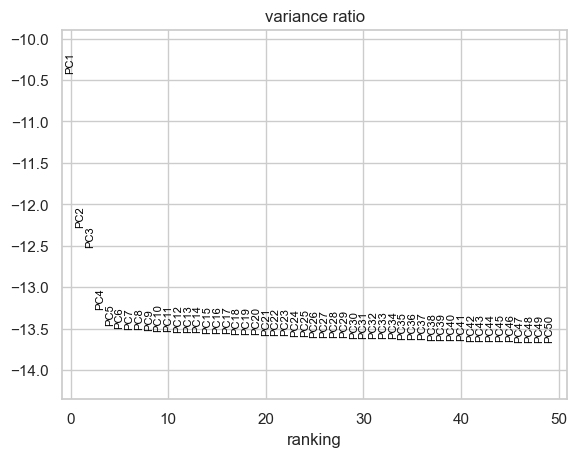

In [142]:
with plt.rc_context():
    sc.pl.pca_variance_ratio(sc_commonDiffFeatures_adata, n_pcs=50, log=True, show=False)
    plt.savefig(figures_dir + "/pca_variance_ratio.pdf", bbox_inches="tight")

In [143]:
sc.pp.neighbors(sc_commonDiffFeatures_adata, n_pcs = 50, n_neighbors = 30, random_state=0)


Text(34.875, 0.5, 'num_feature_per_cell')

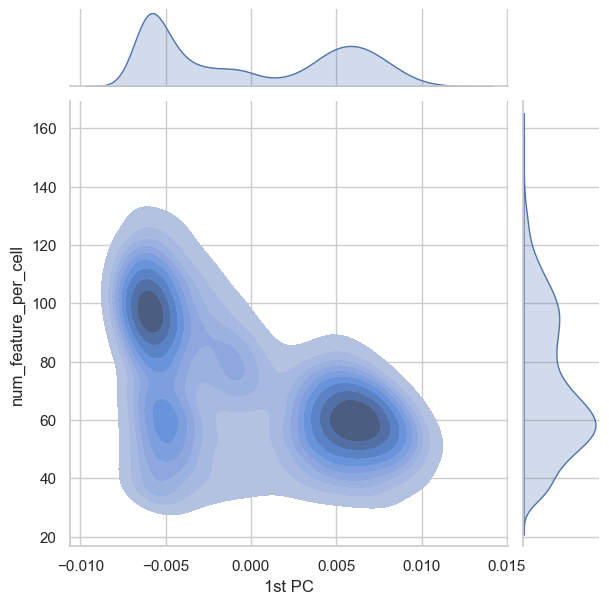

In [144]:
seqDepth_PC1_plot = sns.jointplot(
    x=sc_commonDiffFeatures_adata.obsm['X_pca'][:,0],
    y=np.sqrt(sc_commonDiffFeatures_adata.obsm['num_feature_per_cell']),
    kind="kde",fill=True, 
)
plt.xlabel("1st PC")
plt.ylabel("num_feature_per_cell")


In [145]:
## correlation
np.corrcoef(sc_commonDiffFeatures_adata.obsm['X_pca'][:,0],
    np.sqrt(sc_commonDiffFeatures_adata.obsm['num_feature_per_cell']))

array([[ 1.        , -0.52824237],
       [-0.52824237,  1.        ]])

### 11 -  apply UMAP & leiden clustering

In [146]:
leiden_resolution=2.0
leiden_key="leiden_"+ str(leiden_resolution)

In [147]:
sc.tl.umap(sc_commonDiffFeatures_adata, random_state=0)

In [148]:
sc.tl.leiden(sc_commonDiffFeatures_adata, resolution=leiden_resolution,key_added=leiden_key, random_state=0)

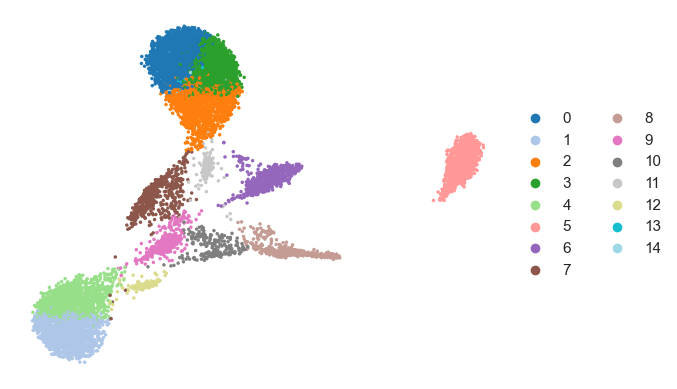

In [149]:
with plt.rc_context():
    sc.pl.umap(sc_commonDiffFeatures_adata, color=leiden_key, show=False,size=25 , add_outline=False, frameon=False, title="",palette="tab20")
    plt.savefig(figures_dir + "/"+ leiden_key+ ".pdf", bbox_inches="tight")

#### loook at sequencing depth

In [150]:
sc_commonDiffFeatures_adata.obs['num_feature_per_cell_'] = sc_commonDiffFeatures_adata.obsm['num_feature_per_cell']

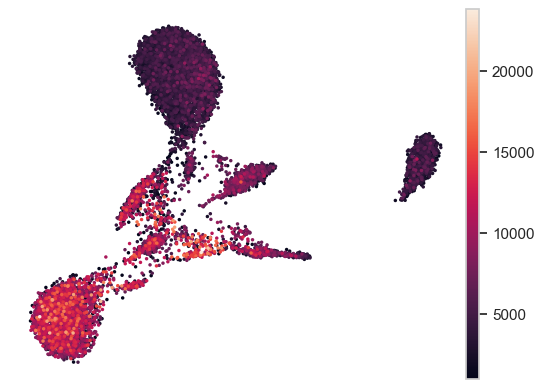

<Figure size 640x480 with 0 Axes>

In [151]:
with plt.rc_context():  
    sc.pl.umap(sc_commonDiffFeatures_adata, color='num_feature_per_cell_', add_outline=False, frameon=False,title ="", save=False, size=25 )
    plt.savefig(figures_dir + "/seq_depth_umap.pdf", bbox_inches="tight")

### 12 - from pseudobulks according to the cluster assignments


In [152]:
cell_cluster_assignments = pd.DataFrame(sc_commonDiffFeatures_adata.obs[leiden_key].copy())
cell_cluster_assignments


,leiden_2.0
cell_IDs,
AAACGAAAGCAGAGCT-1,9
AAACGAAAGCTGATTC-1,7
AAACGAAAGGACCGAT-1,1
AAACGAAAGGAGTACC-1,2
AAACGAAAGTCGTATC-1,7
...,...
TTTGTGTTCCTAAAGC-1,1
TTTGTGTTCCTCATTA-1,0
TTTGTGTTCGGTCGAC-1,1


In [153]:
cell_cluster_sizes = pd.DataFrame(cell_cluster_assignments[leiden_key].value_counts())
cell_cluster_sizes['leiden_clusters'] = cell_cluster_sizes.index
cell_cluster_sizes.head()

,count,leiden_clusters
leiden_2.0,,
0,1546,0
1,1426,1
2,1307,2
3,1305,3
4,1075,4


In [154]:
for clust_id in set(sc_commonDiffFeatures_adata.obs[leiden_key].values):
    clust_df= sc_commonDiffFeatures_adata[sc_commonDiffFeatures_adata.obs[leiden_key]==clust_id]

In [155]:
cell_types = ([(r.split('_')[0]) for r in clust_df.obs[leiden_key].index])

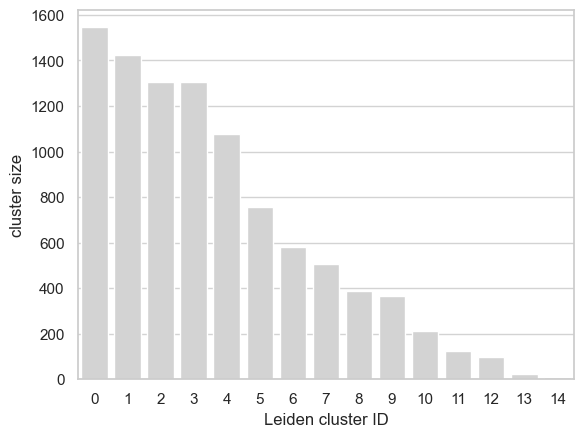

In [156]:
# plot a bar chart
sns.set_style("whitegrid")
ax= sns.barplot(
    y="count", 
    x="leiden_clusters", 
    data=cell_cluster_sizes, 
    color='lightgrey');
ax.yaxis.grid(True,color="lightgrey")
ax.axes.set_xlabel("Leiden cluster ID")
ax.axes.set_ylabel("cluster size")

plt.savefig(figures_dir + "/cluster_sizes_"+leiden_key+".pdf", dpi=250)

In [157]:
pseudobulk_commonFeatures_adata = scATAcat.generate_bulk_sparse_AnnData(scATAcat.get_pseudobulk_matrix_ext(adata_to_subset=sc_commonFeatures_adata, adata_to_get_clusters=sc_commonDiffFeatures_adata, cluster_key=leiden_key  ,method = 'sum'))

In [158]:
scATAcat.preprocessing_libsize_norm_log2(pseudobulk_commonFeatures_adata)

AnnData object with n_obs × n_vars = 15 × 859230
    obs: 'cell_types'
    var: 'cCREs'
    layers: 'libsize_norm_log2'

In [159]:
scATAcat.preprocessing_libsize_norm_log2(bulk_commonFeatures_adata)

AnnData object with n_obs × n_vars = 94 × 859230
    obs: 'cell_types'
    var: 'cCREs'
    layers: 'libsize_norm_log2'

### 13 - Projection


#### processing 

In [160]:
bulk_commonDiffFeatures_adata = scATAcat.subset_adata_vars(bulk_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

In [161]:
bulk_commonDiffFeatures_adata.obs

,cell_types
cell_types,
GABA_1,GABA_1
GABA_2,GABA_2
GABA_3,GABA_3
GABA_4,GABA_4
GABA_5,GABA_5
...,...
OLIG_20,OLIG_20
OLIG_21,OLIG_21
OLIG_22,OLIG_22


In [162]:
pseudobulk_commonDiffFeatures_adata = scATAcat.subset_adata_vars(pseudobulk_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

In [163]:
scATAcat.preprocessing_standardization(bulk_commonDiffFeatures_adata, input_layer_key="libsize_norm_log2", zero_center=True)

adding std with default keywords
adding mean with default keywords


AnnData object with n_obs × n_vars = 94 × 25302
    obs: 'cell_types'
    var: 'cCREs', 'feature_std', 'feature_mean'
    layers: 'libsize_norm_log2', 'libsize_norm_log2_std'

In [164]:
bulk_commonDiffFeatures_adata

AnnData object with n_obs × n_vars = 94 × 25302
    obs: 'cell_types'
    var: 'cCREs', 'feature_std', 'feature_mean'
    layers: 'libsize_norm_log2', 'libsize_norm_log2_std'

In [165]:
scATAcat.preprocessing_standardization(pseudobulk_commonDiffFeatures_adata, input_layer_key="libsize_norm_log2", zero_center=False,
                              output_layer_key= "libsize_norm_log2_bulk_scaled_diff",
                              std_key= None,  mean_key=None,
                              std_ = bulk_commonDiffFeatures_adata.var["feature_std"],
                              mean_= bulk_commonDiffFeatures_adata.var["feature_mean"])

adding std with default keywords
adding mean with default keywords


AnnData object with n_obs × n_vars = 15 × 25302
    obs: 'cell_types'
    var: 'cCREs', 'feature_std', 'feature_mean'
    layers: 'libsize_norm_log2', 'libsize_norm_log2_bulk_scaled_diff'

In [166]:
## as an option, I can add the color codes from the clustering/ sc adata as a paramater for the pseudobulk matrix 
leiden_color_key = leiden_key+"_colors"
pseudobulk_commonDiffFeatures_adata.uns[leiden_color_key] = sc_commonDiffFeatures_adata.uns[leiden_color_key]

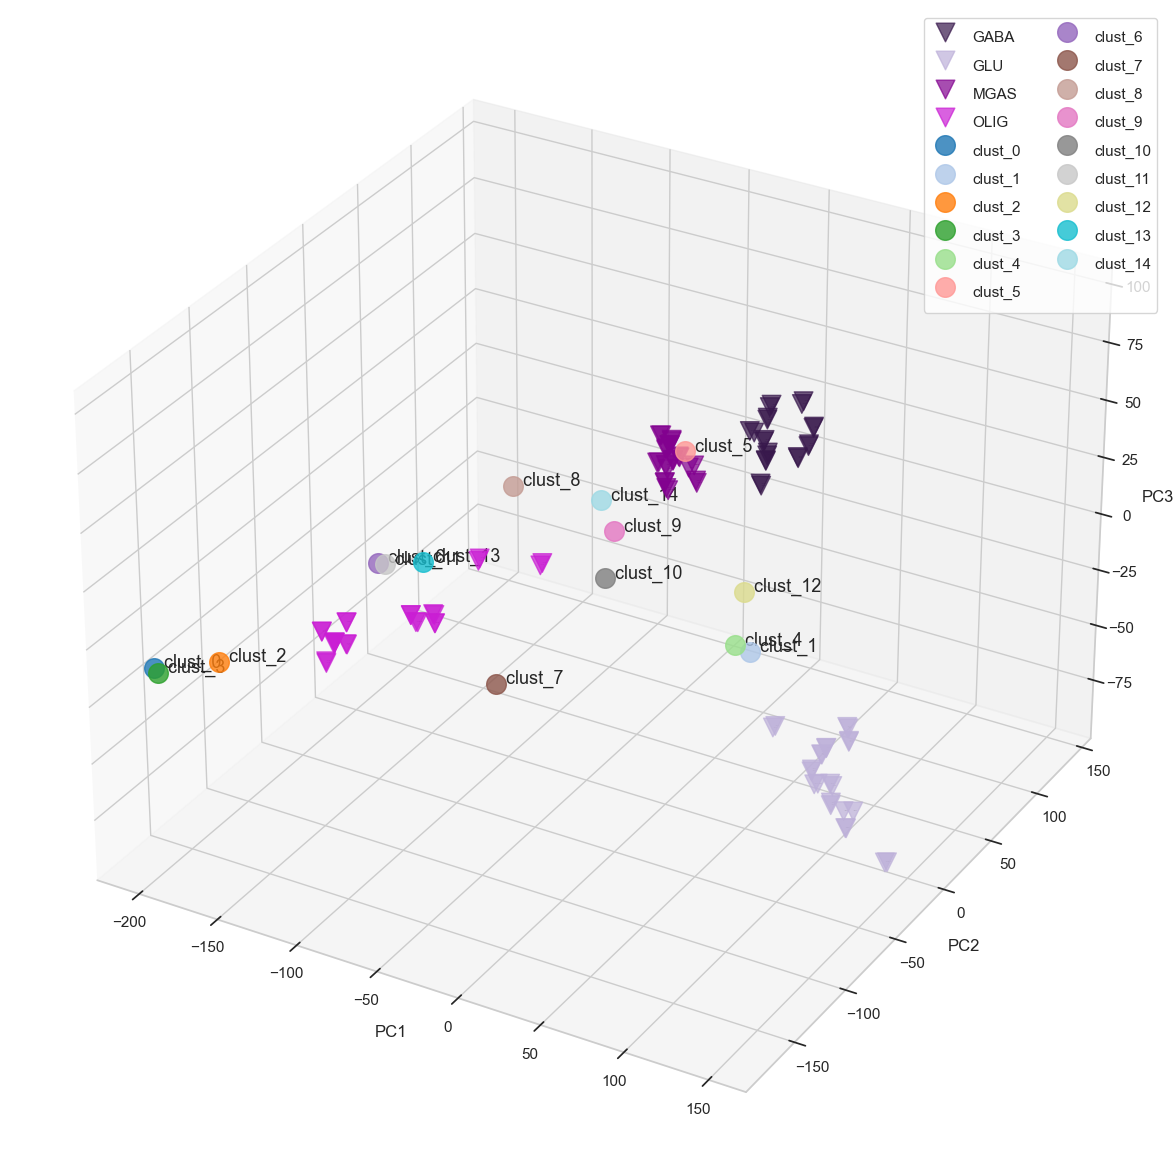

In [167]:
result= scATAcat.projection(prototype_adata=bulk_commonDiffFeatures_adata, pseudobulk_adata=pseudobulk_commonDiffFeatures_adata, prototype_layer_key = "libsize_norm_log2_std", pseudobulk_layer_key="libsize_norm_log2_bulk_scaled_diff", color_key=leiden_color_key, pseudobulk_label_font_size =13, prototype_label_font_size = 0, 
                             prototype_colors = ['#38184C',  "#BDB0D9", "#82018F","#CA1ED4", "#DB90AA"],pseudobulk_colors =  None, pseudobulk_point_size=200, prototype_point_size=180, pseudobulk_point_alpha=0.8, prototype_point_alpha=0.7, cmap='twilight_shifted', prototype_legend = True, pseudobulk_legend = True, save_path = figures_dir + "projection.png")


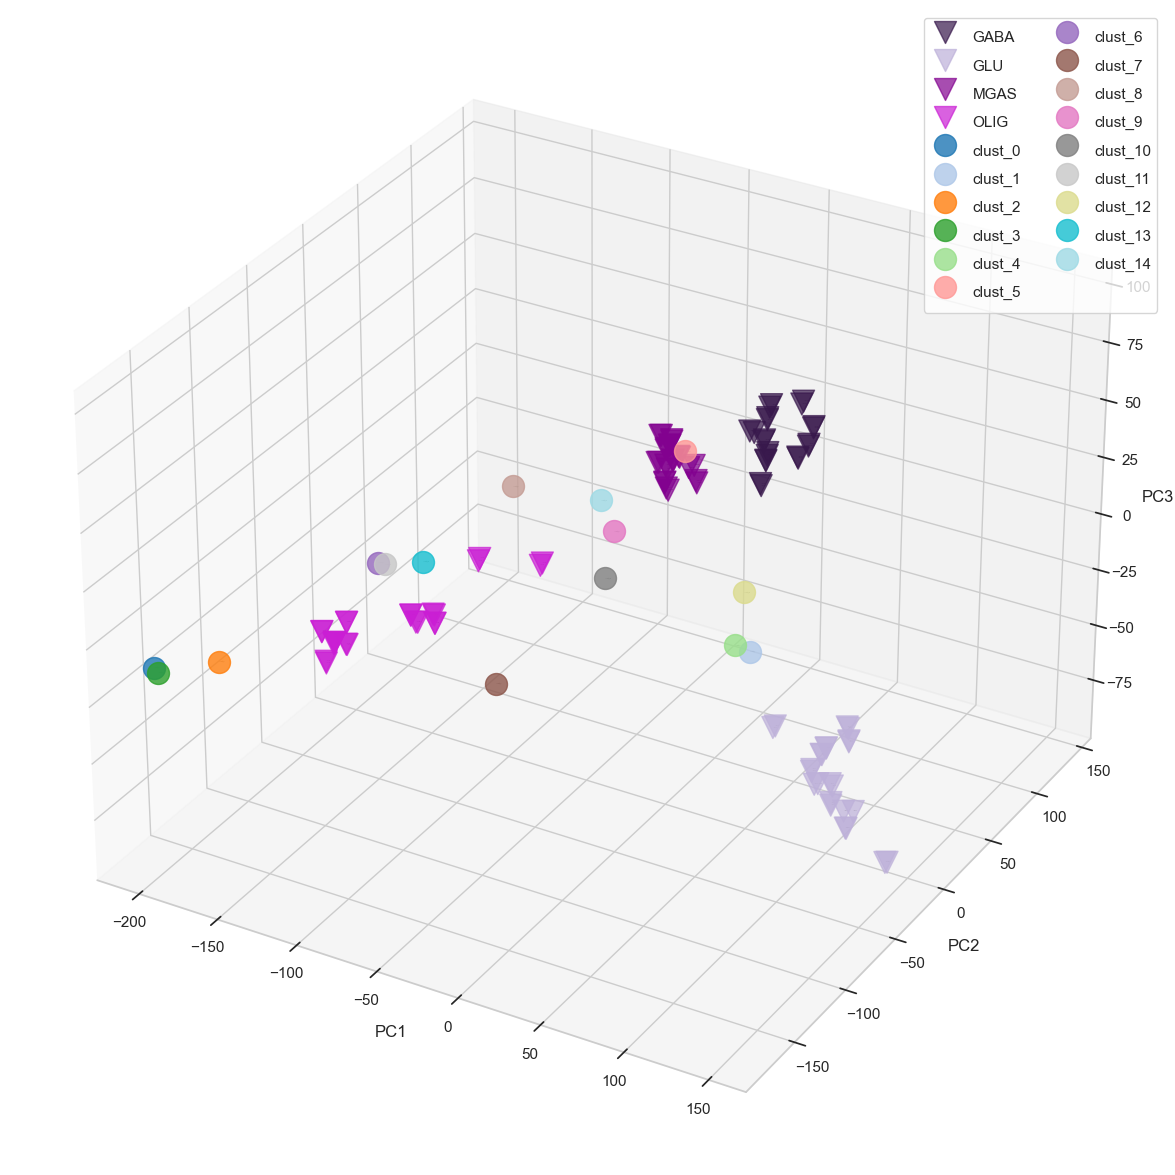

In [168]:
result_noLabel = scATAcat.projection(prototype_adata=bulk_commonDiffFeatures_adata, pseudobulk_adata=pseudobulk_commonDiffFeatures_adata, prototype_layer_key = "libsize_norm_log2_std", pseudobulk_layer_key="libsize_norm_log2_bulk_scaled_diff", color_key=leiden_color_key, pseudobulk_label_font_size =0, prototype_label_font_size =0, 
                             prototype_colors = ['#38184C',  "#BDB0D9", "#82018F","#CA1ED4", "#DB90AA"],pseudobulk_colors =  None, pseudobulk_point_size=250, prototype_point_size=250, pseudobulk_point_alpha=0.8, prototype_point_alpha=0.7, cmap='twilight_shifted', prototype_legend = True, pseudobulk_legend = True, save_path = figures_dir + "projection_noLabel.png")


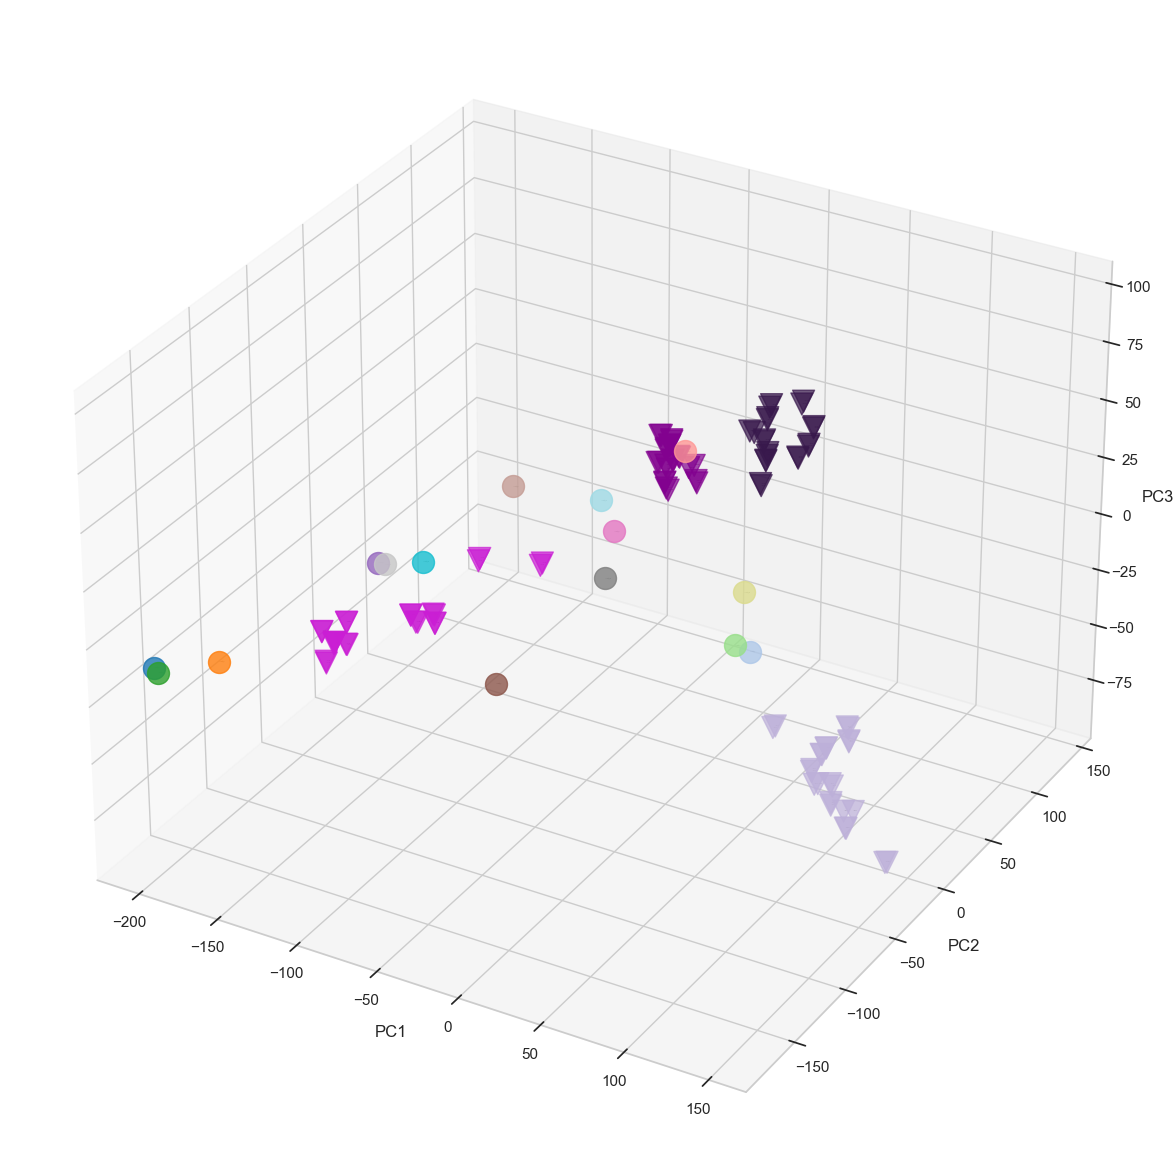

In [169]:
result_noLabel_noLegend = scATAcat.projection(prototype_adata=bulk_commonDiffFeatures_adata, pseudobulk_adata=pseudobulk_commonDiffFeatures_adata, prototype_layer_key = "libsize_norm_log2_std", pseudobulk_layer_key="libsize_norm_log2_bulk_scaled_diff", color_key=leiden_color_key, pseudobulk_label_font_size =0, prototype_label_font_size =0, 
                            prototype_colors = ['#38184C',  "#BDB0D9", "#82018F","#CA1ED4", "#DB90AA"],pseudobulk_colors =  None, pseudobulk_point_size=250, prototype_point_size=250, pseudobulk_point_alpha=0.8, prototype_point_alpha=0.7, cmap='twilight_shifted', prototype_legend = False, pseudobulk_legend = False, save_path = figures_dir + "projection_noLabel_noLegend.png")


### 14 - Assign annotations to clusters


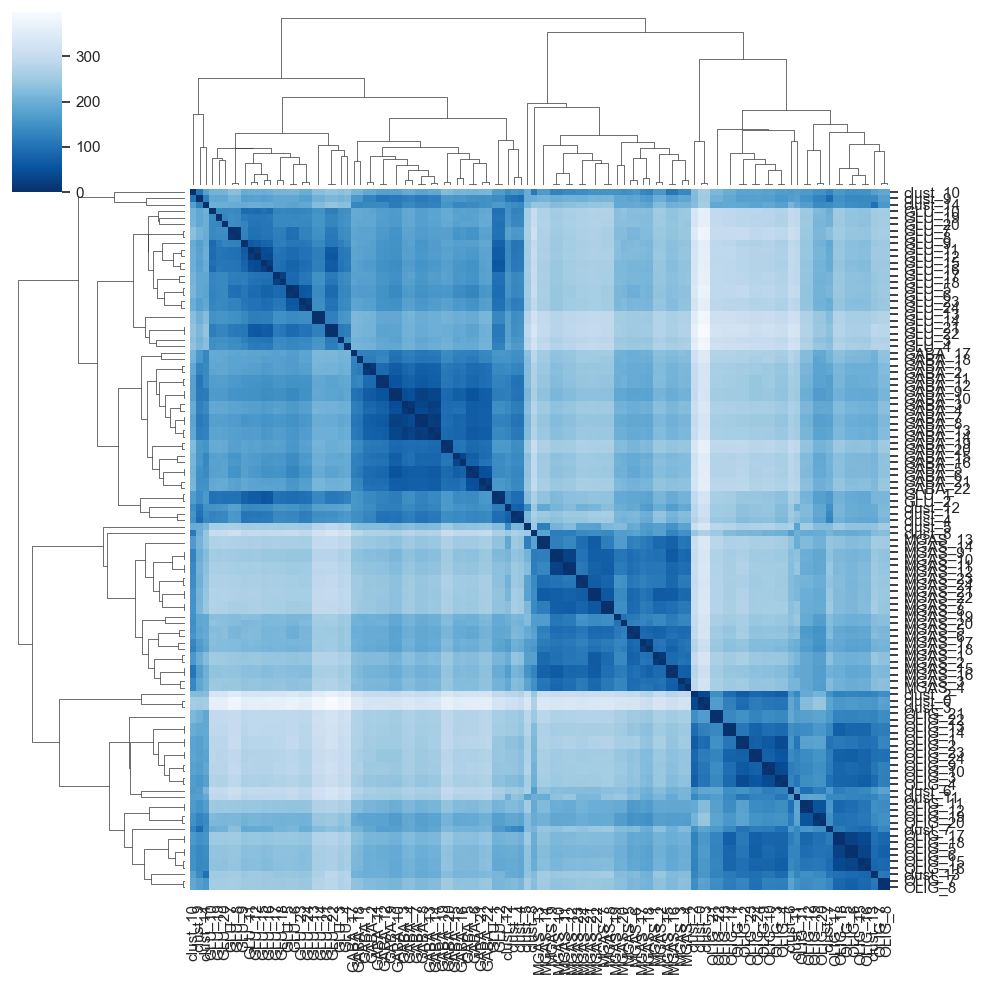

In [170]:
heatmap = scATAcat.plot_pca_dist_heatmap(result[1],result[2])

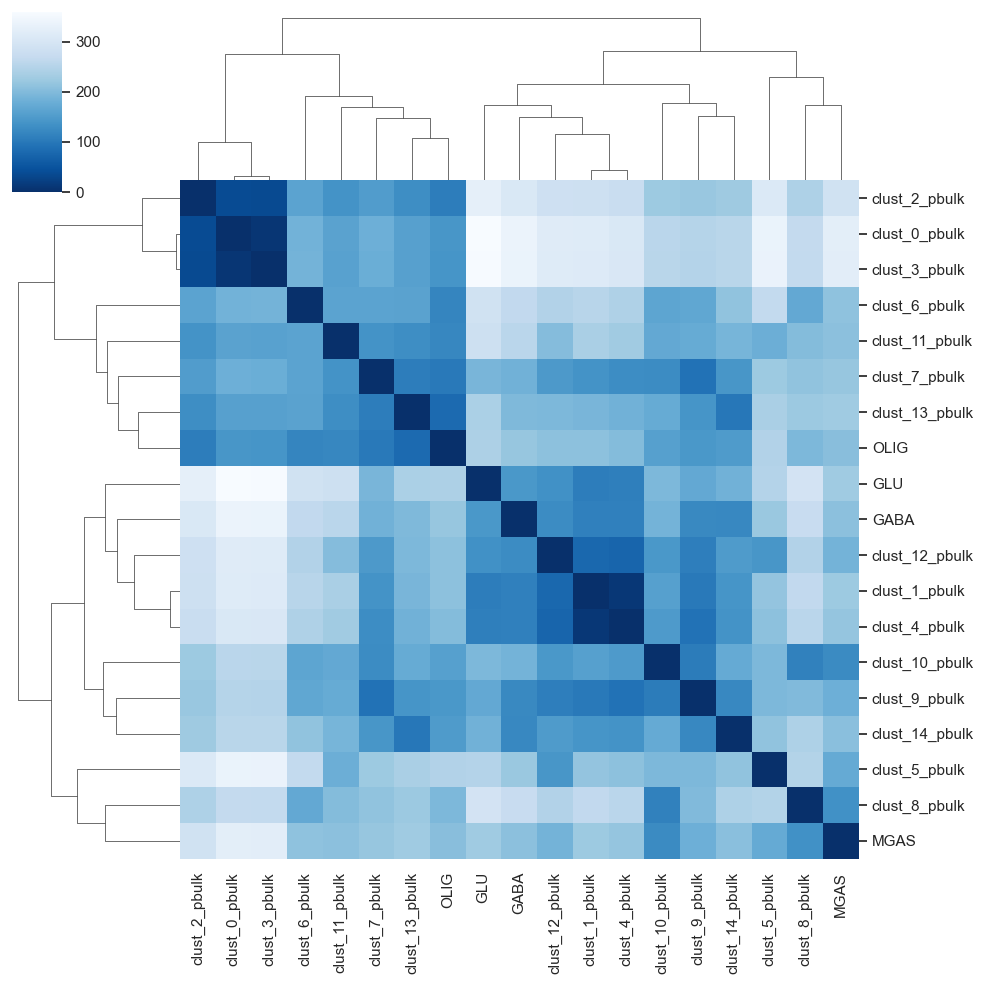

In [171]:
centroid_heatmap =  scATAcat.plot_pca_dist_cent_heatmap(result[1],result[2])


In [172]:
heatmap[0].savefig(figures_dir +"/heatmap.png") 
centroid_heatmap[0].savefig(figures_dir +"/centroid_heatmap.png") 


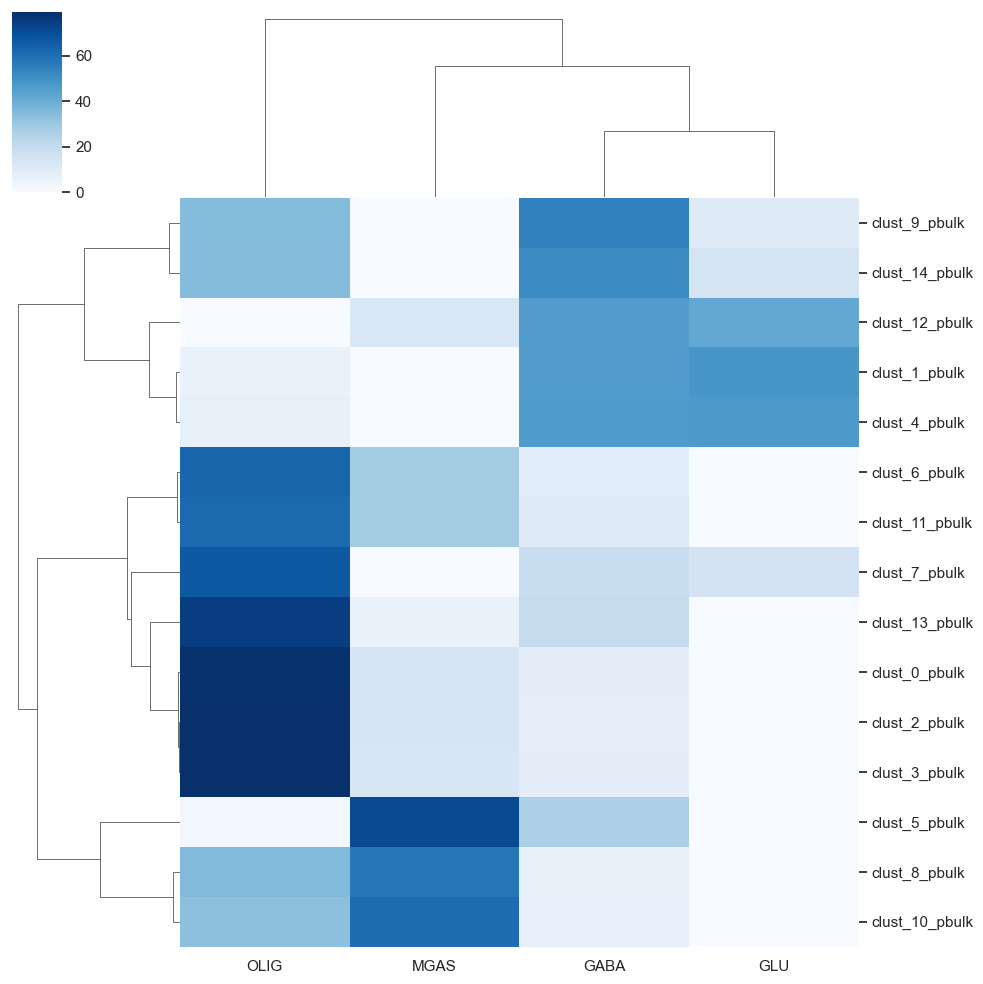

In [173]:
sns.clustermap(scATAcat.get_pseudobulk_to_prototype_distance(centroid_heatmap[1], pbulk_to_prototype=True).T,yticklabels=True,xticklabels=True, cmap="Blues")

In [174]:
prototype_colors = ['#38184C',  "#BDB0D9", "#82018F","#CA1ED4", "#DB90AA"],

In [175]:
scATAcat.get_closest_prototype_to_pseudobulk(centroid_heatmap[1])

{'clust_0_pbulk': 'OLIG',
 'clust_10_pbulk': 'MGAS',
 'clust_11_pbulk': 'OLIG',
 'clust_12_pbulk': 'GABA',
 'clust_13_pbulk': 'OLIG',
 'clust_14_pbulk': 'GABA',
 'clust_1_pbulk': 'GLU',
 'clust_2_pbulk': 'OLIG',
 'clust_3_pbulk': 'OLIG',
 'clust_4_pbulk': 'GLU',
 'clust_5_pbulk': 'MGAS',
 'clust_6_pbulk': 'OLIG',
 'clust_7_pbulk': 'OLIG',
 'clust_8_pbulk': 'MGAS',
 'clust_9_pbulk': 'GABA'}

In [176]:
clusterID_prediction_dict = scATAcat.get_closest_prototype_to_pseudobulk(centroid_heatmap[1])
clusterID_prediction_dict

{'clust_0_pbulk': 'OLIG',
 'clust_10_pbulk': 'MGAS',
 'clust_11_pbulk': 'OLIG',
 'clust_12_pbulk': 'GABA',
 'clust_13_pbulk': 'OLIG',
 'clust_14_pbulk': 'GABA',
 'clust_1_pbulk': 'GLU',
 'clust_2_pbulk': 'OLIG',
 'clust_3_pbulk': 'OLIG',
 'clust_4_pbulk': 'GLU',
 'clust_5_pbulk': 'MGAS',
 'clust_6_pbulk': 'OLIG',
 'clust_7_pbulk': 'OLIG',
 'clust_8_pbulk': 'MGAS',
 'clust_9_pbulk': 'GABA'}

In [177]:
paper_annotations = pd.read_csv("/project/scATAC_analysis/10X_scATAC_HumanBrain_Corces2020/analysis/cell_annotations_by_the_paper/CAUD_06_0615_neuronal_cluster_df_cell_type_annotations.csv", index_col=0)

In [178]:
paper_annotations.annotations.value_counts()

annotations
Oligodendrocytes     4309
InhibitoryNeurons    2507
Microglia             779
OPCs                  689
Astrocytes            660
UnknownNeurons        460
ExcitatoryNeurons     370
Doublets              143
NigralNeurons          99
Name: count, dtype: int64

In [117]:
paper_annotations.shape

(10016, 4)

In [118]:
sc_commonDiffFeatures_adata.shape

(9726, 10291)

In [119]:
paper_annotations[paper_annotations.annotations =="Doublets"]

,10x_SingleCell_Barcode,Cluster,annotations,cell_IDs
0,,,,
61,AAACTGCAGAATATCG,Cluster18,Doublets,AAACTGCAGAATATCG-1
340,AACCTTTAGGCAGTGT,Cluster18,Doublets,AACCTTTAGGCAGTGT-1
386,AACGGGACAGCTATAC,Cluster18,Doublets,AACGGGACAGCTATAC-1
419,AACGTACGTCAGTGCC,Cluster18,Doublets,AACGTACGTCAGTGCC-1
442,AACTGTGAGACCAATA,Cluster18,Doublets,AACTGTGAGACCAATA-1
...,...,...,...,...
9608,TTGACGAAGCTATCCA,Cluster18,Doublets,TTGACGAAGCTATCCA-1
9660,TTGAGTGTCCAGAGAG,Cluster18,Doublets,TTGAGTGTCCAGAGAG-1
9679,TTGCACCGTGACGCAA,Cluster18,Doublets,TTGCACCGTGACGCAA-1


In [132]:
paper_annotations[paper_annotations.annotations =="Doublets"][['cell_IDs']]

,cell_IDs
0,
61,AAACTGCAGAATATCG-1
340,AACCTTTAGGCAGTGT-1
386,AACGGGACAGCTATAC-1
419,AACGTACGTCAGTGCC-1
442,AACTGTGAGACCAATA-1
...,...
9608,TTGACGAAGCTATCCA-1
9660,TTGAGTGTCCAGAGAG-1
9679,TTGCACCGTGACGCAA-1


In [133]:
paper_annotations[paper_annotations.annotations =="Doublets"][['cell_IDs']].isin(sc_commonDiffFeatures_adata.obs["cell_IDs"]).any()

cell_IDs    False
dtype: bool

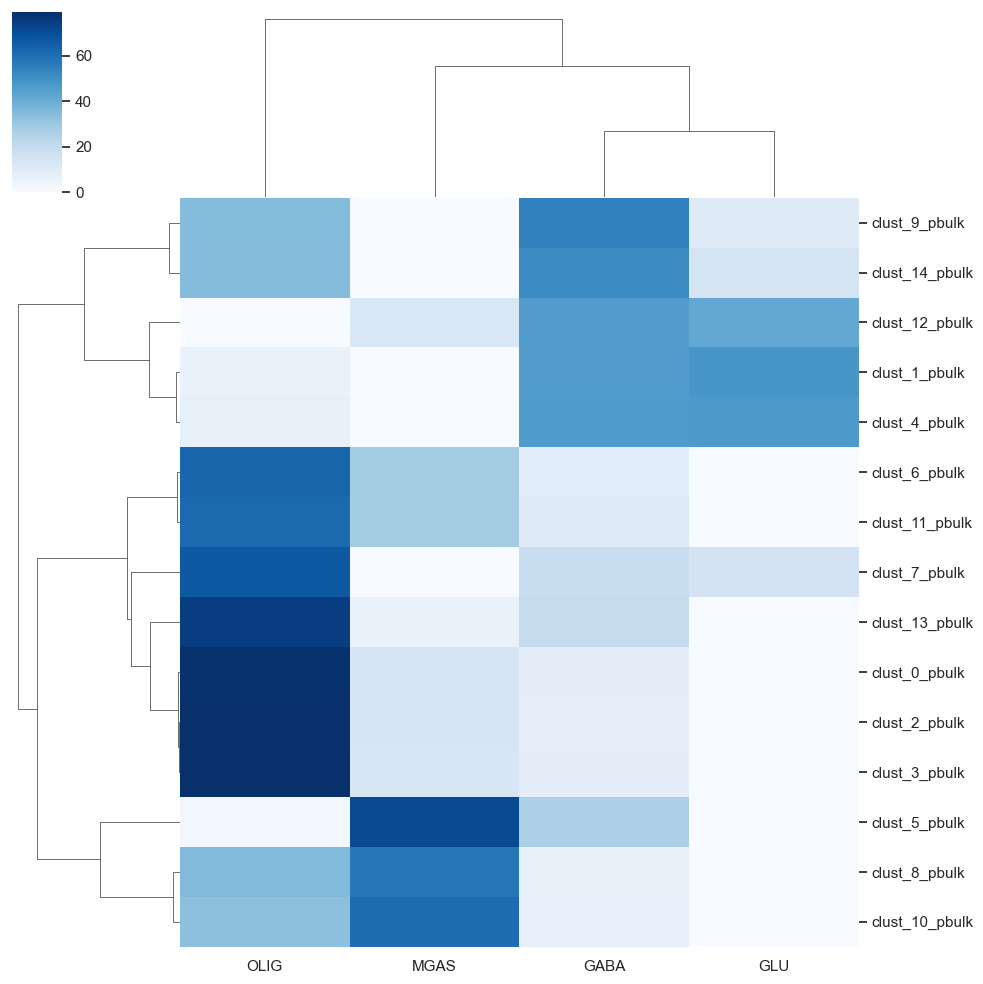

In [179]:
cluster_to_pseudobulk_heatmap_plot = sns.clustermap(scATAcat.get_pseudobulk_to_prototype_distance(centroid_heatmap[1], pbulk_to_prototype=True).T,yticklabels=True,xticklabels=True, cmap="Blues")

In [180]:
cluster_to_pseudobulk_heatmap_plot.savefig(figures_dir+"/cluster_to_pseudobulk_heatmap_plot.png") 


In [181]:
cluster_to_pseudobulk_heatmap_plot.savefig(figures_dir+"/cluster_to_pseudobulk_heatmap_plot.svg") 


### 15- Post hoc analysis

In [182]:
cell_cluster_assignments_with_predictions = copy.deepcopy(cell_cluster_assignments)

#### match the clusterID with predicted cell type

In [183]:
# convert the cell id column to character 
cell_cluster_assignments_with_predictions[leiden_key] = cell_cluster_assignments_with_predictions[leiden_key].astype(str)

In [184]:
cell_cluster_assignments_with_predictions.head()

,leiden_2.0
cell_IDs,
AAACGAAAGCAGAGCT-1,9
AAACGAAAGCTGATTC-1,7
AAACGAAAGGACCGAT-1,1
AAACGAAAGGAGTACC-1,2
AAACGAAAGTCGTATC-1,7


In [185]:
# refortmat the dict suct that it mactes the clust ID col
clusterID_prediction_dict_edited = dict((''.join(filter(str.isdigit, key)), value) for (key, value) in clusterID_prediction_dict.items())
clusterID_prediction_dict_edited

{'0': 'OLIG',
 '10': 'MGAS',
 '11': 'OLIG',
 '12': 'GABA',
 '13': 'OLIG',
 '14': 'GABA',
 '1': 'GLU',
 '2': 'OLIG',
 '3': 'OLIG',
 '4': 'GLU',
 '5': 'MGAS',
 '6': 'OLIG',
 '7': 'OLIG',
 '8': 'MGAS',
 '9': 'GABA'}

In [186]:
cell_cluster_assignments_with_predictions

,leiden_2.0
cell_IDs,
AAACGAAAGCAGAGCT-1,9
AAACGAAAGCTGATTC-1,7
AAACGAAAGGACCGAT-1,1
AAACGAAAGGAGTACC-1,2
AAACGAAAGTCGTATC-1,7
...,...
TTTGTGTTCCTAAAGC-1,1
TTTGTGTTCCTCATTA-1,0
TTTGTGTTCGGTCGAC-1,1


In [187]:
cell_cluster_assignments_with_predictions['scATAcat_annotation'] = cell_cluster_assignments_with_predictions[leiden_key].map(clusterID_prediction_dict_edited)

In [188]:
cell_cluster_assignments_with_predictions['cell_IDs'] = cell_cluster_assignments_with_predictions.index

In [189]:
cell_cluster_assignments_with_predictions.to_csv(output_dir +"/scATAcat_annotations.csv")

## export AnnData object

In [190]:

with open(output_dir +'/sc_commonDiffFeatures_adata.pkl', 'wb') as f:
    pickle.dump(sc_commonDiffFeatures_adata, f)

In [191]:
cell_cluster_assignments.to_csv(output_dir +"cell_cluster_assignments.csv")